In [6]:
def hex_to_geoboundary(value):
    if isinstance(value,str):
        return shapely.geometry.Polygon(h3.h3_to_geo_boundary(value, True))
    else:
        return np.nan

# Descriptive Analysis

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
from shapely import wkt
import h3
from datetime import date
import pyarrow.parquet as pq
import pyarrow as pa
#from fastparquet import write
#import parquet
import contextily as ctx

In [11]:
df = pd.read_parquet("../data/df_cleaned_18_06_2021.parquet")
df = df.iloc[0:100000]

In [12]:
df["PU_Centroid"] = gpd.points_from_xy(df["Pickup Centroid Latitude"], df["Pickup Centroid Latitude"])
df["DO_Centroid"] = gpd.points_from_xy(df["Dropoff Centroid Latitude"], df["Dropoff Centroid Latitude"])                                                   
#df = df.drop(columns = ["Pickup Centroid Latitude","Pickup Centroid Longitude","Dropoff Centroid Latitude","Dropoff Centroid Longitude"])
df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"],format = '%m/%d/%Y %I:%M:%S %p')
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"],format = '%m/%d/%Y %I:%M:%S %p')
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_MONTH_NAME,PU_WEEKDAY_NAME,PU_YEAR,PU_MONTH,PU_WEEKDAY,PU_HOUR,PU_HOUR_OF_WEEK,PU_FOUR_HOURLY,PU_Centroid,DO_Centroid
10019694,0186acc0c8d50828e6dc5c9072ace58101e3e1b1,9a38858dc2ace73a20f89a976154131a733daf1f11e8d6...,2017-05-20 23:45:00,2017-05-20 23:45:00,360.0,1.30,1.703106e+10,1.703107e+10,6.0,7.0,...,May,Saturday,2017,5,5,24,144,5/5,POINT (41.93624 41.93624),POINT (41.92185 41.92185)
7792802,7d0830d9dbbd03a9e1b5d1d99cd41d99d7b8fb90,b4d59da1d7b8c002094752251906d9a3bcc6c7ea71a15f...,2017-04-21 22:15:00,2017-04-21 22:15:00,300.0,0.40,1.703108e+10,1.703108e+10,8.0,8.0,...,April,Friday,2017,4,4,23,119,5/5,POINT (41.90950 41.90950),POINT (41.90749 41.90749)
7493958,171ea5e4956fe55a58f9ec3be65238af8b79c4c2,38c32bfda2f77c2a57f33a9e3fcf7edb8e996f59bc2254...,2017-04-18 10:30:00,2017-04-18 10:45:00,379.0,1.00,1.703184e+10,1.703128e+10,32.0,28.0,...,April,Tuesday,2017,4,1,11,35,3/5,POINT (41.88099 41.88099),POINT (41.88530 41.88530)
5984763,a6da0037deae54685ba3a1a559ae6a33b9028bd9,e2c349c7cbb608d552aa0b5814031943f13641ef9e50d8...,2017-03-28 16:15:00,2017-03-28 16:15:00,317.0,0.96,1.703108e+10,1.703108e+10,8.0,8.0,...,March,Tuesday,2017,3,1,17,41,4/5,POINT (41.89197 41.89197),POINT (41.89503 41.89503)
4498023,58bc23a32b790e568d3c50bc38e5dd473cbc9fcf,cbdd490649df25aa771979bed8930b199d27a990ccdb42...,2017-03-09 14:30:00,2017-03-09 14:30:00,360.0,1.00,1.703128e+10,1.703184e+10,28.0,32.0,...,March,Thursday,2017,3,3,15,87,3/5,POINT (41.88530 41.88530),POINT (41.88099 41.88099)


In [13]:
df.columns

Index(['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp',
       'Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Pickup Centroid Location',
       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
       'Dropoff Centroid  Location', 'PU_H3', 'DO_H3', 'PU_MONTH_NAME',
       'PU_WEEKDAY_NAME', 'PU_YEAR', 'PU_MONTH', 'PU_WEEKDAY', 'PU_HOUR',
       'PU_HOUR_OF_WEEK', 'PU_FOUR_HOURLY', 'PU_Centroid', 'DO_Centroid'],
      dtype='object')

In [14]:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_MONTH_NAME,PU_WEEKDAY_NAME,PU_YEAR,PU_MONTH,PU_WEEKDAY,PU_HOUR,PU_HOUR_OF_WEEK,PU_FOUR_HOURLY,PU_Centroid,DO_Centroid
10019694,0186acc0c8d50828e6dc5c9072ace58101e3e1b1,9a38858dc2ace73a20f89a976154131a733daf1f11e8d6...,2017-05-20 23:45:00,2017-05-20 23:45:00,360.0,1.30,1.703106e+10,1.703107e+10,6.0,7.0,...,May,Saturday,2017,5,5,24,144,5/5,POINT (41.93624 41.93624),POINT (41.92185 41.92185)
7792802,7d0830d9dbbd03a9e1b5d1d99cd41d99d7b8fb90,b4d59da1d7b8c002094752251906d9a3bcc6c7ea71a15f...,2017-04-21 22:15:00,2017-04-21 22:15:00,300.0,0.40,1.703108e+10,1.703108e+10,8.0,8.0,...,April,Friday,2017,4,4,23,119,5/5,POINT (41.90950 41.90950),POINT (41.90749 41.90749)
7493958,171ea5e4956fe55a58f9ec3be65238af8b79c4c2,38c32bfda2f77c2a57f33a9e3fcf7edb8e996f59bc2254...,2017-04-18 10:30:00,2017-04-18 10:45:00,379.0,1.00,1.703184e+10,1.703128e+10,32.0,28.0,...,April,Tuesday,2017,4,1,11,35,3/5,POINT (41.88099 41.88099),POINT (41.88530 41.88530)
5984763,a6da0037deae54685ba3a1a559ae6a33b9028bd9,e2c349c7cbb608d552aa0b5814031943f13641ef9e50d8...,2017-03-28 16:15:00,2017-03-28 16:15:00,317.0,0.96,1.703108e+10,1.703108e+10,8.0,8.0,...,March,Tuesday,2017,3,1,17,41,4/5,POINT (41.89197 41.89197),POINT (41.89503 41.89503)
4498023,58bc23a32b790e568d3c50bc38e5dd473cbc9fcf,cbdd490649df25aa771979bed8930b199d27a990ccdb42...,2017-03-09 14:30:00,2017-03-09 14:30:00,360.0,1.00,1.703128e+10,1.703184e+10,28.0,32.0,...,March,Thursday,2017,3,3,15,87,3/5,POINT (41.88530 41.88530),POINT (41.88099 41.88099)


In [15]:
df.describe()

,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,PU_MONTH,PU_WEEKDAY,PU_HOUR,PU_HOUR_OF_WEEK
count,100000.000000,100000.000000,6.975700e+04,6.947900e+04,92819.000000,90934.000000,100000.000000,100000.000000,73603.000000,100000.000000,100000.000000,92821.000000,92821.000000,91204.000000,91204.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,840.236440,3.714602,1.703139e+10,1.703137e+10,24.524968,21.966613,13.782366,1.615856,0.002328,0.947242,16.455201,41.899053,-87.658843,41.899282,-87.652538,5.947060,2.923200,14.685670,84.842470
std,758.110307,5.340126,3.452932e+05,3.327924e+05,19.868309,17.530278,12.585468,2.770794,0.282566,2.627481,15.770057,0.038100,0.074657,0.037600,0.058683,3.092364,1.892992,6.004597,45.304273
min,61.000000,0.000000,1.703101e+10,1.703101e+10,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,41.660136,-87.913625,41.660136,-87.913625,1.000000,0.000000,1.000000,1.000000
25%,360.000000,0.800000,1.703108e+10,1.703108e+10,8.000000,8.000000,6.250000,0.000000,0.000000,0.000000,7.500000,41.880994,-87.649907,41.880994,-87.655879,3.000000,1.000000,11.000000,44.000000
50%,600.000000,1.500000,1.703128e+10,1.703128e+10,28.000000,22.000000,8.500000,0.000000,0.000000,0.000000,10.000000,41.892042,-87.632746,41.892073,-87.632746,6.000000,3.000000,15.000000,86.000000
75%,995.000000,3.600000,1.703184e+10,1.703183e+10,32.000000,32.000000,14.250000,2.000000,0.000000,1.000000,16.500000,41.901207,-87.625192,41.907492,-87.626146,9.000000,4.000000,19.000000,120.000000
max,7020.000000,141.800000,1.703198e+10,1.703198e+10,77.000000,77.000000,117.500000,100.000000,75.000000,99.500000,125.000000,42.009623,-87.534903,42.016046,-87.534903,11.000000,6.000000,24.000000,168.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 10019694 to 8330016
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Trip ID                     100000 non-null  object        
 1   Taxi ID                     99949 non-null   object        
 2   Trip Start Timestamp        100000 non-null  datetime64[ns]
 3   Trip End Timestamp          100000 non-null  datetime64[ns]
 4   Trip Seconds                100000 non-null  float64       
 5   Trip Miles                  100000 non-null  float64       
 6   Pickup Census Tract         69757 non-null   float64       
 7   Dropoff Census Tract        69479 non-null   float64       
 8   Pickup Community Area       92819 non-null   float64       
 9   Dropoff Community Area      90934 non-null   float64       
 10  Fare                        100000 non-null  float64       
 11  Tips                        100

In [17]:
df.max()

Trip ID                       fffff2c7da2975a0174ba3d180b8e3ecf97d4d9d
Trip Start Timestamp                               2017-11-30 23:30:00
Trip End Timestamp                                 2017-11-30 23:45:00
Trip Seconds                                                    7020.0
Trip Miles                                                       141.8
Pickup Census Tract                                      17031980100.0
Dropoff Census Tract                                     17031980100.0
Pickup Community Area                                             77.0
Dropoff Community Area                                            77.0
Fare                                                             117.5
Tips                                                             100.0
Tolls                                                             75.0
Extras                                                            99.5
Trip Total                                                       125.0
Paymen

## Descriptive Analysis - Weather

In [18]:
fields = ['datetime', 'Chicago']


temp_chicago1 = pd.read_csv('temperature.csv', skipinitialspace=True, usecols=fields)
temp_chicago = temp_chicago1.rename(columns={'Chicago': 'Temperature'})
temp_chi = temp_chicago[(temp_chicago["datetime"]>='2017-01-01')& (temp_chicago["datetime"]<='2017-12-31')]
temp_chi

,datetime,Temperature
37260,2017-01-01 00:00:00,274.06
37261,2017-01-01 01:00:00,272.94
37262,2017-01-01 02:00:00,272.14
37263,2017-01-01 03:00:00,270.97
37264,2017-01-01 04:00:00,270.14
...,...,...
45248,2017-11-29 20:00:00,281.34
45249,2017-11-29 21:00:00,281.69
45250,2017-11-29 22:00:00,281.07
45251,2017-11-29 23:00:00,280.06


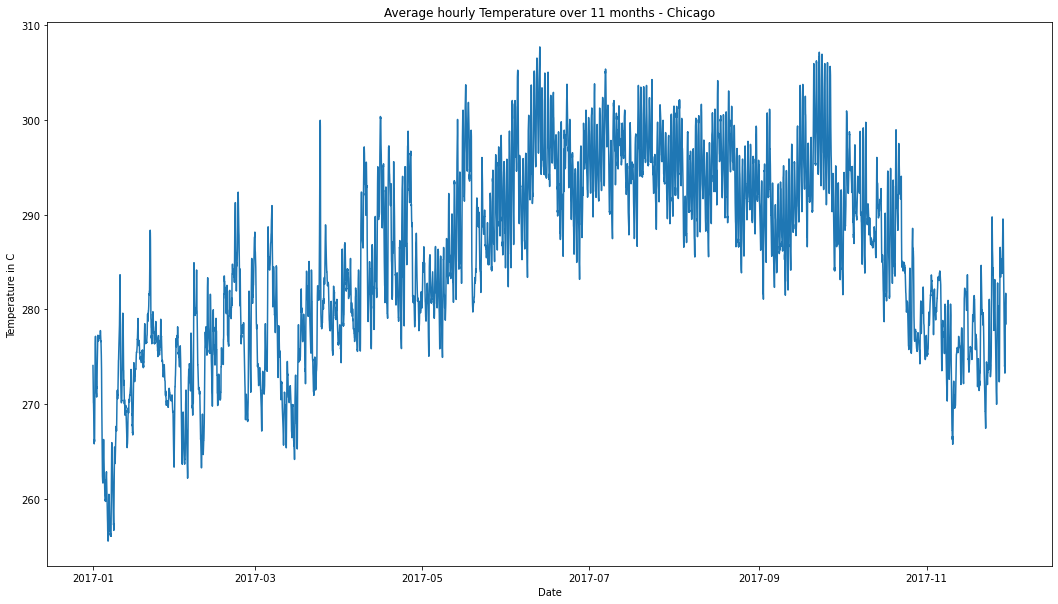

In [19]:
#Convert date value into right datetime format
#temp_chi['DATE']= pd.to_datetime(temp_chi['DATE1'], format='Y-m-d H:M:S')
dateRange_gi = pd.DataFrame({'datetime' : pd.date_range(start='01/01/2017 00:00:00', end='11/30/2017 00:00:00', freq='H')}) 

#Pyplot
plt.figure(figsize = (18,10))
#plt.xticks(np.arange(np.datetime64('2017-01-01'), np.datetime64('2017-11-30')))

# plt.plot(temp_chi['DATE'],temp_chi['Temperature'])
plt.plot(dateRange_gi['datetime'],temp_chi['Temperature'])

plt.xlabel('Date')
plt.ylabel('Temperature in C')
plt.title('Average hourly Temperature over 11 months - Chicago')
plt.show()

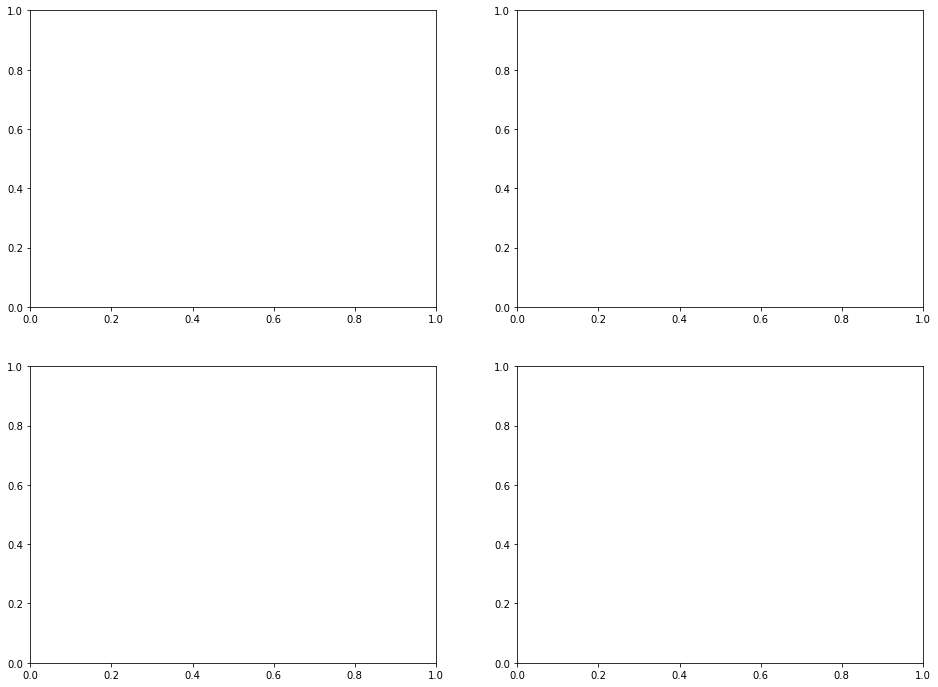

In [20]:
## Wetter-Plots zusammenfassen
fig,axes=plt.subplots(2,2,figsize=(16,12))

In [21]:
fields = ['datetime', 'Chicago']


hum_chicago1 = pd.read_csv('humidity.csv', skipinitialspace=True, usecols=fields)
hum_chicago = hum_chicago1.rename(columns={'Chicago': 'Humidity'})
hum_chi = hum_chicago[(hum_chicago["datetime"]>='2017-01-01')& (hum_chicago["datetime"]<='2017-12-31')]
hum_chi

,datetime,Humidity
37260,2017-01-01 00:00:00,100.0
37261,2017-01-01 01:00:00,50.0
37262,2017-01-01 02:00:00,100.0
37263,2017-01-01 03:00:00,63.0
37264,2017-01-01 04:00:00,73.0
...,...,...
45248,2017-11-29 20:00:00,52.0
45249,2017-11-29 21:00:00,65.0
45250,2017-11-29 22:00:00,96.0
45251,2017-11-29 23:00:00,75.0


In [22]:
fields = ['datetime', 'Chicago']


wind_chicago1 = pd.read_csv('wind_speed.csv', skipinitialspace=True, usecols=fields)
wind_chicago = wind_chicago1.rename(columns={'Chicago': 'Wind_Speed'})
wind_chi = wind_chicago[(wind_chicago["datetime"]>='2017-01-01')& (wind_chicago["datetime"]<='2017-12-31')]
wind_chi

,datetime,Wind_Speed
37260,2017-01-01 00:00:00,4.0
37261,2017-01-01 01:00:00,4.0
37262,2017-01-01 02:00:00,3.0
37263,2017-01-01 03:00:00,3.0
37264,2017-01-01 04:00:00,1.0
...,...,...
45248,2017-11-29 20:00:00,2.0
45249,2017-11-29 21:00:00,4.0
45250,2017-11-29 22:00:00,2.0
45251,2017-11-29 23:00:00,2.0


In [23]:
fields = ['datetime', 'Chicago']


des_chicago1 = pd.read_csv('weather_description.csv', skipinitialspace=True, usecols=fields)
des_chicago = des_chicago1.rename(columns={'Chicago': 'Weather_Description'})
des_chi = des_chicago[(des_chicago["datetime"]>='2017-01-01')& (des_chicago["datetime"]<='2017-12-31')]
des_chi

,datetime,Weather_Description
37260,2017-01-01 00:00:00,overcast clouds
37261,2017-01-01 01:00:00,scattered clouds
37262,2017-01-01 02:00:00,sky is clear
37263,2017-01-01 03:00:00,sky is clear
37264,2017-01-01 04:00:00,sky is clear
...,...,...
45248,2017-11-29 20:00:00,few clouds
45249,2017-11-29 21:00:00,sky is clear
45250,2017-11-29 22:00:00,few clouds
45251,2017-11-29 23:00:00,sky is clear


In [24]:
weather_hourly = temp_chi.merge(hum_chicago, how='left', on='datetime')
weather_hourly1 = weather_hourly.merge(wind_chi, how='left', on='datetime')
weather_hourly2 = weather_hourly1.merge(des_chi, how='left', on='datetime')
weather_hourly2.head()
#https://www.kaggle.com/selfishgene/historical-hourly-weather-data?select=weather_description.csv

,datetime,Temperature,Humidity,Wind_Speed,Weather_Description
0,2017-01-01 00:00:00,274.06,100.0,4.0,overcast clouds
1,2017-01-01 01:00:00,272.94,50.0,4.0,scattered clouds
2,2017-01-01 02:00:00,272.14,100.0,3.0,sky is clear
3,2017-01-01 03:00:00,270.97,63.0,3.0,sky is clear
4,2017-01-01 04:00:00,270.14,73.0,1.0,sky is clear


## Descriptive Analysis - Temporal (not final)

In [25]:
df['Date'] = pd.to_datetime(df['Trip Start Timestamp'], format='%m/%d/%Y %I:%M:%S %p')
df.index = df.Date
df_weekPerYear = pd.Series(df['Date'].resample('1W').count())

In [26]:
df_weekPerYear

Date
2017-01-01     251
2017-01-08    1785
2017-01-15    2155
2017-01-22    1899
2017-01-29    1969
2017-02-05    1882
2017-02-12    2037
2017-02-19    2016
2017-02-26    2076
2017-03-05    2181
2017-03-12    2278
2017-03-19    2500
2017-03-26    2283
2017-04-02    2130
2017-04-09    2459
2017-04-16    2076
2017-04-23    2265
2017-04-30    2185
2017-05-07    2318
2017-05-14    2330
2017-05-21    2403
2017-05-28    2138
2017-06-04    2158
2017-06-11    2512
2017-06-18    2368
2017-06-25    2290
2017-07-02    1962
2017-07-09    1676
2017-07-16    2124
2017-07-23    2137
2017-07-30    2079
2017-08-06    2187
2017-08-13    1996
2017-08-20    2109
2017-08-27    1833
2017-09-03    1910
2017-09-10    1756
2017-09-17    2200
2017-09-24    2092
2017-10-01    1879
2017-10-08    2105
2017-10-15    2134
2017-10-22    2218
2017-10-29    2018
2017-11-05    1954
2017-11-12    2087
2017-11-19    2020
2017-11-26    1328
2017-12-03    1252
Freq: W-SUN, Name: Date, dtype: int64

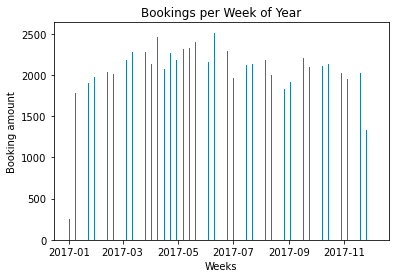

In [27]:
import matplotlib.pyplot as plt

plt.bar(df_weekPerYear.index,df_weekPerYear)
plt.xlabel('Weeks')
plt.ylabel('Booking amount')
plt.title('Bookings per Week of Year')
plt.show()

In [28]:
df_monthly = pd.Series(df['Date'].resample('1M').count())


In [29]:
df['start_month'] = df['Trip Start Timestamp'].dt.month
df['end_month'] = df['Trip End Timestamp'].dt.month
df['startdtinh'] = df['Trip Start Timestamp'].dt.floor('d')
df['enddtinh'] = df['Trip End Timestamp'].dt.floor('d')

In [30]:
df22= df.groupby('start_month')['Trip Seconds']
df33= df.groupby('end_month')['Trip Seconds']

In [31]:
df22.head()

Date
2017-05-20 23:45:00     360.0
2017-04-21 22:15:00     300.0
2017-04-18 10:30:00     379.0
2017-03-28 16:15:00     317.0
2017-03-09 14:30:00     360.0
2017-11-28 17:15:00     360.0
2017-05-21 16:30:00     539.0
2017-05-02 20:00:00    1560.0
2017-11-20 14:45:00     720.0
2017-03-08 11:45:00     480.0
2017-01-03 07:45:00     623.0
2017-04-28 14:30:00     420.0
2017-07-24 22:30:00    1920.0
2017-10-05 12:30:00     188.0
2017-05-01 20:00:00     907.0
2017-11-29 18:00:00    3480.0
2017-09-16 15:45:00    3300.0
2017-08-17 19:45:00    3840.0
2017-02-02 01:00:00     845.0
2017-01-21 16:45:00    1860.0
2017-09-08 23:45:00     360.0
2017-02-15 21:45:00     780.0
2017-04-02 21:15:00     531.0
2017-06-07 20:45:00    2202.0
2017-09-28 13:15:00     240.0
2017-10-06 13:15:00    1409.0
2017-02-15 15:00:00     480.0
2017-06-28 16:45:00    4080.0
2017-07-01 17:45:00    1140.0
2017-11-13 13:00:00     619.0
2017-05-18 05:30:00     180.0
2017-10-20 19:30:00     300.0
2017-03-04 01:45:00     591.0
2017-

In [32]:
df_monthly

Date
2017-01-31     8618
2017-02-28     8049
2017-03-31    10260
2017-04-30     9500
2017-05-31     9942
2017-06-30    10056
2017-07-31     8760
2017-08-31     9007
2017-09-30     8469
2017-10-31     9162
2017-11-30     8177
Freq: M, Name: Date, dtype: int64

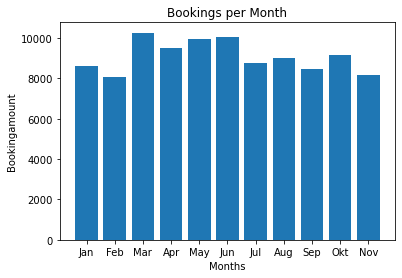

In [33]:
months =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov' ]
plt.bar(months,df_monthly) #Karlsruhe
plt.xlabel('Months')
plt.ylabel('Bookingamount')
plt.title('Bookings per Month')
plt.show()

In [34]:
#check this and the method before
week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

#array that will get filled in in the following
df_weekday = []

#add weekday to bike_set of Karlsruhe
for weekday in range(0,7):
    df_weekday.append([weekday,df['Date'].loc[(df['Date'].dt.dayofweek) == weekday].count()])
df_weekday = pd.DataFrame(df_weekday)



In [35]:
df_weekday

,0,1
0,0,13064
1,1,14416
2,2,15485
3,3,16395
4,4,16449
5,5,13193
6,6,10998


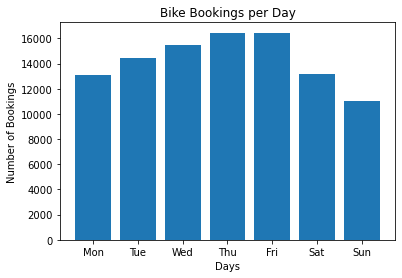

In [36]:
# Chart day of week data
plt.bar(week,df_weekday[1])

# Labeling
plt.xlabel('Days')
plt.ylabel('Number of Bookings')
plt.title('Bike Bookings per Day')
plt.show()

In [37]:
dayhour = []

# Determine the amount of hourly trips
for hour in range(0,24):
    dayhour.append([hour,df['Date'].loc[(df['Date'].dt.hour) == hour].count()])
dayhour = pd.DataFrame(dayhour)


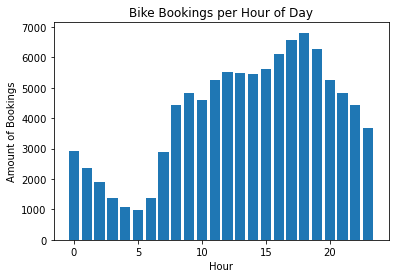

In [38]:
# Bar chart the hour of day data and give labels
plt.bar(dayhour[0], dayhour[1])
plt.xlabel('Hour')
plt.ylabel('Amount of Bookings')
plt.title('Bike Bookings per Hour of Day')
plt.show()

In [40]:
# total = []
# for i in range(len(dff)):
#     n = dff['']
#     dates.append(n)

dfc =  df[["Fare", "Tips","Tolls", "Extras"]]

avgfare = dff.groupby('start_month')['Fare'].mean()
avgtips = dff.groupby('start_month')['Tips'].mean()
avgtolls = dff.groupby('start_month')['Tolls'].mean()
avgextras = dff.groupby('start_month')['Extras'].mean()
months =avgfare.index

# totalperc1 = avgfare.merge(avgtips, how='left', on='start_month')
# totalperc2 = totalperc1.merge(avgtolls, how='left', on='start_month')
# totalperc = totalperc2.merge(avgextras, how='left', on='start_month')


Data = {'month': months,
        'fare': avgfare,
        'tips': avgtips,
        'tolls': avgtolls,
        'extras': avgextras
       }

dfcc = pd.DataFrame(Data,columns=['month','fare','tips','tolls','extras'])
dfcc
#figure size
dfcc.plot(
    x = 'month',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True)



KeyError: 'start_month'

## Trip Duration along 1 hour Buckets and 4 hour buckets


In [ ]:
avgdura = dff.groupby('start_month')['Trip Seconds'].mean()
avgdura


In [ ]:
months =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov' ]
plt.bar(months,avgdura) #Karlsruhe
plt.xlabel('Months')
plt.ylabel('Average Trip Duration')
plt.title('Avg Trip Duration per Month')
plt.show()

In [ ]:
avgduraday = dff.groupby('startdtinh')['Trip Seconds'].mean()
months =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov' ]
plt.plot(avgduraday) 
plt.xlabel('Day')
plt.ylabel('Average Trip Duration')
plt.title('Avg Trip Duration per Day')
plt.show()

In [ ]:
#check this and the method before
week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

#array that will get filled in in the following
df_weekday = []

#['Trip Start Timestamp']
#df.groupby(df["'Trip Start Timestamp'"].dt.hour)["value"].mean().plot(
#add weekday to bike_set of Karlsruhe
for weekday in range(0,7):
    df_weekday.append([weekday,df['Trip Start Timestamp'].loc[(df['Date'].dt.dayofweek) == weekday].dt.hour.mean()])
df_weekday = pd.DataFrame(df_weekday)

df_weekday

# Chart day of week data
plt.bar(week,df_weekday[1])

# Labeling, check
plt.xlabel('Days')
plt.ylabel('Average Starting Time')
plt.title('Average Starting Time per Day')
plt.show()

In [ ]:
air_quality.groupby(air_quality["datetime"].dt.hour)["value"].mean().plot(

In [ ]:
avgdistance = df.groupby('start_month')['Trip Miles'].mean()
avgdistance


months =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov' ]
plt.bar(months,avgdistance) 
plt.xlabel('Months')
plt.ylabel('Average Trip Distance')
plt.title('Avg Trip Distance per Month')
plt.show()

In [ ]:
avgdistanceday = df.groupby('startdtinh')['Trip Seconds'].mean()
#months =['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov' ]
plt.plot(avgdistanceday) 
plt.xlabel('Day')
plt.ylabel('Average Trip Distance')
plt.title('Avg Trip Distance per Day')
plt.show()

## Descriptive Analysis - Geographic

### Get H3 Resolution in Data

In [ ]:
h3_resolution = h3.h3_get_resolution(df["PU_H3"].iloc[0])
h3_resolution

### Build H3 Grid

In [ ]:
chicago_fence = gpd.read_file("../data/chicago.geojson")
chicago_boundary_pol = chicago_fence.geometry[0][1]
poly_geojson = gpd.GeoSeries([chicago_boundary_pol]).__geo_interface__
# Parse out geometry key from GeoJSON dictionary
poly_geojson = poly_geojson['features'][0]['geometry'] 

# Create an empty dataframe to write data into
h3_df = pd.DataFrame([],columns=['h3_id','h3_geo_boundary','h3_centroid'])

# Fill the dictionary with H3 Hexagons
h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)

for h3_hex in h3_hexes:
    h3_geo_boundary = shapely.geometry.Polygon(
        h3.h3_to_geo_boundary(h3_hex,geo_json=True))
    h3_centroid = h3.h3_to_geo(h3_hex)
    h3_df.loc[len(h3_df)]=[
        h3_hex,
        h3_geo_boundary,
        h3_centroid
        ]
h3_gdf = gpd.GeoDataFrame(h3_df,geometry="h3_geo_boundary")

In [ ]:
h3_gdf

### Group to H3 Slices

In [ ]:
def group_h3_slice(df,hour_feature_name,H3_feature_name,slices):
    df_grouped = df.copy()
    divider = 24/slices
    df_grouped["hour_slice"] = np.floor(df_grouped[hour_feature_name] / divider).astype(int)
    df_grouped = df_grouped.groupby(["hour_slice",H3_feature_name]).agg(count=(H3_feature_name,"count"),
                                                                       avgduration=("Trip Seconds","mean"))
    df_grouped["H3"] = df_grouped.index.get_level_values(1)
    df_grouped["geometry"] = df_grouped.apply(lambda x: hex_to_geoboundary(x["H3"]),axis=1)
    df_grouped["hour_slice"] = df_grouped.index.get_level_values(0)
    return gpd.GeoDataFrame(df_grouped, geometry='geometry')

gdf_sliced_pu = group_h3_slice(df,"PU_HOUR","PU_H3",3)
#gdf_sliced_do = group_h3_slice(df,"DO_HOUR","DO_H3",3)

In [ ]:
gdf_sliced_pu.sample(10)

### Plot Sliced Heatmap

In [ ]:
def plot_chicago_heatmap(df,ax,h3_column,feature_column,h3_gdf,filter_value=0,cmap="plasma"):
    data = df[[h3_column,feature_column]]
    data = pd.merge(h3_gdf,data,how="left",left_on="h3_id",right_on=h3_column)
    data[feature_column] = data[feature_column].fillna(0)
    data_below = data[data[feature_column]<=filter_value]
    data_above = data[data[feature_column]>filter_value]
    data_below.plot(ax=ax,color="grey",alpha=0.5,edgecolor="none")
    plot = data_above.plot(ax=ax,column=feature_column,cmap=cmap)
    return plot

fig,axes = plt.subplots(1,3,figsize = (16,8))

chicago_fence = gpd.read_file("../data/chicago-community-areas.geojson")
i = 0
for ax in axes:
    plot_df = gdf_sliced_pu[gdf_sliced_pu["hour_slice"]==i]
    chicago_fence.plot(ax=ax,edgecolor="white",color="none")
    plot = plot_chicago_heatmap(plot_df,ax,"H3","count",h3_gdf,50)
    ctx.add_basemap(ax=ax,zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago_fence.plot(ax=ax,alpha=0) #das macht nur die skalierung richtig
    #ax.set_xlim
    i=i+1

In [ ]:
df_grouped_pu2 = df.groupby("PU_PART_OF_DAY","PU_H3").agg(avgduration=("Trip Seconds","mean"),
                                                          count=("Trip Total","count")
)
df_grouped_pu2

In [ ]:
df_grouped_pu = df.groupby("PU_H3").agg(avgduration=("Trip Seconds","mean"),
                                        avgdistance=("Trip Miles","mean"),
                                        avgpay=("Trip Total","mean"),
                                        count=("Trip Total","count"),
                                        revenue=("Trip Total","sum")
)
df_grouped_pu

In [ ]:
df_pu_grouped2["geometry"] = df_pu_grouped2.apply(lambda x: hex_to_geoboundary(x["PU_H3"]),axis=1)
df_pu_grouped2 = gpd.GeoDataFrame(df_pu_grouped2, geometry='geometry')
df_pu_grouped2

In [ ]:
dff6 = dff5.rename(columns={'Trip Seconds_y': 'Average_Duration', 'Trip Miles_y': 'Average_Distance', 'Trip Total_y': 'Average_Payment' })
dff6

## Write results in parquet file 